In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from architectures.RAFT_SlotAttention import RAFT_SlotAttention
from argparse import ArgumentParser


# RAFT_SlotAttention config
parser = ArgumentParser()
parser.add_argument('--output_dir', type=str, default="outputs")
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--visualize_freq', type=int, default=1000)
parser.add_argument('--eval_freq', type=int, default=2500)
parser.add_argument('--dataset_path', type=str, default="data/movi_a")
parser.add_argument('--DEBUG', action='store_true', default=False)
RAFT_SlotAttention.add_argparse_args(parser)
cfg = parser.parse_args(["--raft_weights_path", "raft-things.pth"])


In [4]:
from architectures.slot_attention import SlotAttention, SoftPositionEmbed
from architectures.raft import RAFT_encoder

encoder_raft = RAFT_encoder(cfg)
encoder_pos = SoftPositionEmbed(cfg.hid_dim, (cfg.resolution, cfg.resolution))

slot_attention = SlotAttention(
            num_slots=cfg.num_slots,
            dim=4096,
            iters=cfg.num_iterations,
            eps=1e-8,
            hidden_dim=1024)

In [5]:
import torch
from movi_dataset import FlowPairMoviDetectron

dataset = torch.utils.data.DataLoader(
    FlowPairMoviDetectron("train", None, (128, 128), prefix="data/movi_a", num_frames=2, gt_flow=True),
    batch_size=4,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=lambda x: x)

sample = next(iter(dataset))
print(sample[0].keys())

(128, 128)
Assuming dataset name is movi_a
dict_keys(['category', 'frame_id', 'gap', 'flow', 'height', 'width', 'rgb', 'sem_seg', 'instances'])


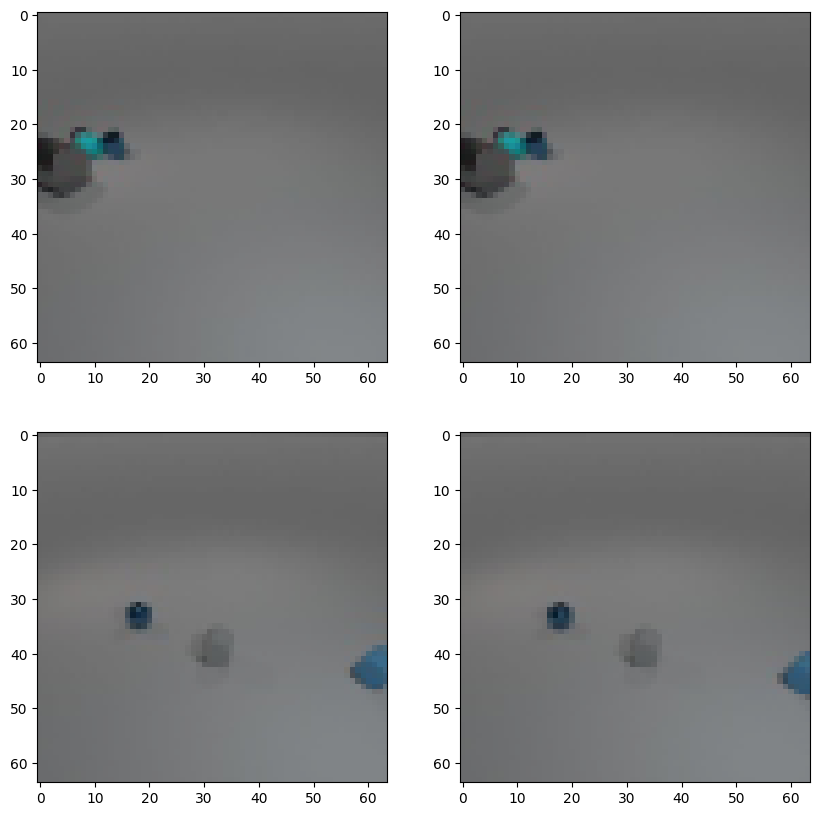

In [6]:
from matplotlib import pyplot as plt
import torchvision.transforms as T

frames = torch.stack([a['rgb'] for a in sample]).to(int)  # B, F, C, H, W


BATCH = 0

image1_small = T.Resize(size=64)(frames[BATCH,0]).contiguous()
image2_small = T.Resize(size=64)(frames[BATCH,1]).contiguous()

# display side by side
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image1_small.detach().cpu().permute(1, 2, 0))
plt.subplot(2, 2, 2)
plt.imshow(image1_small.detach().cpu().permute(1, 2, 0))

BATCH = 1
image1_small = T.Resize(size=64)(frames[BATCH,0]).contiguous()
image2_small = T.Resize(size=64)(frames[BATCH,1]).contiguous()
plt.subplot(2, 2, 3)
plt.imshow(image1_small.detach().cpu().permute(1, 2, 0))
plt.subplot(2, 2, 4)
plt.imshow(image2_small.detach().cpu().permute(1, 2, 0))
plt.show()



In [7]:
res = encoder_raft(frames)

<Figure size 2000x1000 with 0 Axes>

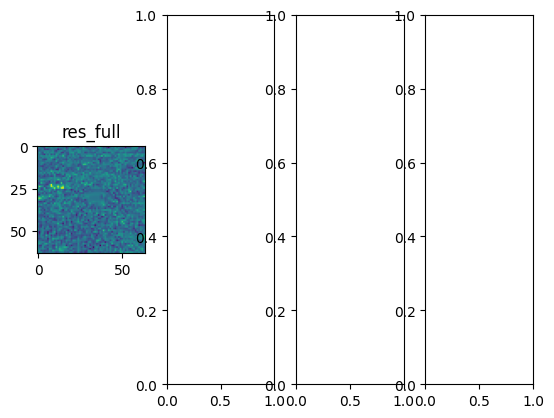

In [8]:
from matplotlib import pyplot as plt
import math

def visualize_correlation(corr_pyramid, batch, i, j):
    # display side by side
    plt.figure(figsize=(20, 10))
    fig, plots = plt.subplots(1, 4)
    for b, (key, pyramid_block) in enumerate(corr_pyramid.items()):
        block = pyramid_block[batch]
        shape = int(math.sqrt(block.shape[0]))
        relations = block.view(shape, shape, 64, 64)[:, :, i, j].detach().cpu().numpy()
        plots[b].imshow(relations)
        plots[b].set_title(key)
    plt.show()


visualize_correlation(res, batch=0, i=25, j=15)


# positional encoding

In [9]:
res_full = res["res_full"] # B, features, H, W
resolution = (res_full.shape[2], res_full.shape[3])
hid_dim = res_full.shape[1]
encoder_pos = SoftPositionEmbed(hid_dim, resolution)

In [10]:
pos_encoded_corr = encoder_pos(res_full.permute(0,2,3,1)) # B, H, W, features
pos_encoded_corr =torch.flatten(pos_encoded_corr, 1, 2) # B, H*W, features


# layer norm and relu

In [11]:
from torch import nn
from torch.nn import functional as F

#x = nn.LayerNorm(pos_encoded_corr.shape[1:])(pos_encoded_corr)

# not used because may cause

In [12]:
slots = slot_attention(pos_encoded_corr)